In [8]:
"""
Fraud Detection - Model Training and Evaluation Pipeline (Jupyter Notebook Version)
Addresses data leakage and implements proper ML workflow
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    f1_score, precision_score, recall_score
)

# Ensemble models
XGBOOST_AVAILABLE = False
LIGHTGBM_AVAILABLE = False
IMBLEARN_AVAILABLE = False
SHAP_AVAILABLE = False

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠️  XGBoost not available")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    print("⚠️  LightGBM not available")

# Imbalanced-learn
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
except ImportError:
    print("⚠️  imbalanced-learn not available")

# SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("⚠️  SHAP not available")

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("="*80)
print("FRAUD DETECTION - MODEL TRAINING PIPELINE")
print("="*80)

⚠️  imbalanced-learn not available
FRAUD DETECTION - MODEL TRAINING PIPELINE


In [9]:
# ==================== CONFIGURATION ====================
class Config:
    # Paths
    DATA_DIR = Path('../data/processed')
    OUTPUT_DIR = Path('../models')
    PLOTS_DIR = Path('../notebooks')
    
    # Model parameters
    RANDOM_STATE = 42
    TEST_SIZE = 0.2
    CV_FOLDS = 5
    
    # Class names
    CLASS_NAMES = ['Legitimate', 'Fraud']
    
Config.OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
Config.PLOTS_DIR.mkdir(exist_ok=True, parents=True)

In [10]:
# ==================== HELPER FUNCTIONS ====================

def load_and_prepare_data(dataset_name='fraud'):
    """Load data and prepare for modeling"""
    print(f"\n{'='*80}")
    print(f"LOADING {dataset_name.upper()} DATASET")
    print(f"{'='*80}")
    
    if dataset_name == 'fraud':
        df = pd.read_csv(Config.DATA_DIR / 'fraud_data_engineered.csv')
        target_col = 'class'
        
        # Columns to drop
        drop_cols = [
            target_col, 'user_id', 'signup_time', 'purchase_time',
            'device_id', 'ip_address', 'ip_integer',
            'account_age_category', 'age_group', 'amount_category',
            'lower_bound', 'upper_bound'  # From IP merge
        ]
        
    elif dataset_name == 'creditcard':
        df = pd.read_csv(Config.DATA_DIR / 'creditcard_engineered.csv')
        target_col = 'Class'
        
        # Columns to drop
        drop_cols = [
            target_col, 'Time', 'Time_Hour', 
            'amount_category'
        ]
    
    else:
        raise ValueError("dataset_name must be 'fraud' or 'creditcard'")
    
    print(f"✓ Loaded: {df.shape}")
    print(f"✓ Target: {target_col}")
    
    # Separate features and target
    drop_cols = [col for col in drop_cols if col in df.columns]
    X = df.drop(columns=drop_cols)
    y = df[target_col]
    
    print(f"\nClass distribution:")
    print(y.value_counts())
    print(f"Fraud rate: {y.mean():.4f}")
    
    return X, y, df

def encode_categorical_features(X_train, X_test):
    """Encode categorical features - FIT ON TRAIN ONLY"""
    print("\n" + "-"*80)
    print("ENCODING CATEGORICAL FEATURES")
    print("-"*80)
    
    # Identify categorical columns
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    
    if not categorical_cols:
        print("✓ No categorical columns to encode")
        return X_train, X_test, {}
    
    print(f"Categorical columns: {categorical_cols}")
    
    encoders = {}
    
    for col in categorical_cols:
        # Use LabelEncoder for high-cardinality features
        le = LabelEncoder()
        
        # Fit on train
        X_train[col + '_encoded'] = le.fit_transform(X_train[col].astype(str))
        
        # Transform test (handle unseen categories)
        X_test_encoded = X_test[col].astype(str).map(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
        X_test[col + '_encoded'] = X_test_encoded
        
        # Store encoder
        encoders[col] = le
        
        # Drop original
        X_train = X_train.drop(columns=[col])
        X_test = X_test.drop(columns=[col])
        
        print(f"✓ Encoded: {col} ({len(le.classes_)} categories)")
    
    return X_train, X_test, encoders

def create_target_encoding_features(X_train, X_test, y_train, categorical_cols):
    """Create fraud rate features - ONLY FROM TRAIN DATA"""
    print("\n" + "-"*80)
    print("CREATING TARGET-BASED FEATURES (NO LEAKAGE)")
    print("-"*80)
    
    train_df = X_train.copy()
    train_df['target'] = y_train.values
    
    global_mean = y_train.mean()
    
    for col in categorical_cols:
        if col not in X_train.columns:
            continue
            
        # Calculate fraud rate on TRAIN only
        fraud_rates = train_df.groupby(col)['target'].agg(['mean', 'count'])
        
        # Smoothing: use global mean for rare categories
        min_samples = 30
        fraud_rates['smoothed_rate'] = fraud_rates.apply(
            lambda x: x['mean'] if x['count'] >= min_samples else global_mean,
            axis=1
        )
        
        # Map to train
        X_train[f'{col}_fraud_rate'] = X_train[col].map(fraud_rates['smoothed_rate'])
        X_train[f'{col}_fraud_rate'].fillna(global_mean, inplace=True)
        
        # Map to test (unseen categories get global mean)
        X_test[f'{col}_fraud_rate'] = X_test[col].map(fraud_rates['smoothed_rate'])
        X_test[f'{col}_fraud_rate'].fillna(global_mean, inplace=True)
        
        print(f"✓ Created {col}_fraud_rate (unique values: {len(fraud_rates)})")
    
    return X_train, X_test

def scale_features(X_train, X_test, method='robust'):
    """Scale numerical features"""
    print("\n" + "-"*80)
    print(f"SCALING FEATURES (method: {method})")
    print("-"*80)
    
    # Select numerical columns only
    numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    if method == 'robust':
        scaler = RobustScaler()
    elif method == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("method must be 'robust' or 'standard'")
    
    # Fit on train, transform both
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
    
    print(f"✓ Scaled {len(numerical_cols)} numerical features")
    
    return X_train_scaled, X_test_scaled, scaler

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=Config.CLASS_NAMES,
                yticklabels=Config.CLASS_NAMES)
    plt.title(title, fontweight='bold', fontsize=14)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    # Add percentages
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            plt.text(j+0.5, i+0.7, f'({cm[i,j]/total*100:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='red')
    
    plt.tight_layout()
    return plt.gcf()

def plot_precision_recall_curve(y_true, y_pred_proba, title='Precision-Recall Curve'):
    """Plot PR curve"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, linewidth=2, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(title, fontweight='bold', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

def plot_roc_curve(y_true, y_pred_proba, title='ROC Curve'):
    """Plot ROC curve"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontweight='bold', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

def evaluate_model(model, X_test, y_test, model_name='Model'):
    """Comprehensive model evaluation"""
    print(f"\n{'='*80}")
    print(f"EVALUATING {model_name.upper()}")
    print(f"{'='*80}")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    metrics = {
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'pr_auc': average_precision_score(y_test, y_pred_proba)
    }
    
    print("\n📊 METRICS:")
    for metric, value in metrics.items():
        print(f"  {metric.upper():.<20} {value:.4f}")
    
    # Classification report
    print("\n📋 CLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred, target_names=Config.CLASS_NAMES))
    
    # Confusion matrix
    print("🎯 CONFUSION MATRIX:")
    cm = confusion_matrix(y_test, y_pred)
    print(f"  TN: {cm[0,0]:>6,}  |  FP: {cm[0,1]:>6,}")
    print(f"  FN: {cm[1,0]:>6,}  |  TP: {cm[1,1]:>6,}")
    
    # Business metrics
    total_fraud = y_test.sum()
    detected_fraud = cm[1,1]
    missed_fraud = cm[1,0]
    false_alarms = cm[0,1]
    
    print("\n💼 BUSINESS METRICS:")
    print(f"  Total Frauds: {total_fraud}")
    print(f"  Detected: {detected_fraud} ({detected_fraud/total_fraud*100:.1f}%)")
    print(f"  Missed: {missed_fraud} ({missed_fraud/total_fraud*100:.1f}%)")
    print(f"  False Alarms: {false_alarms}")
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=Config.CLASS_NAMES,
                yticklabels=Config.CLASS_NAMES, ax=axes[0])
    axes[0].set_title(f'{model_name} - Confusion Matrix', fontweight='bold')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')
    
    # PR Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    axes[1].plot(recall, precision, linewidth=2)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(f'PR Curve (AUC={metrics["pr_auc"]:.4f})', fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[2].plot(fpr, tpr, linewidth=2)
    axes[2].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_title(f'ROC Curve (AUC={metrics["roc_auc"]:.4f})', fontweight='bold')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(Config.PLOTS_DIR / f'{model_name.lower()}_evaluation.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return metrics, y_pred, y_pred_proba

def cross_validate_model(model, X, y, model_name='Model', cv=5):
    """Perform stratified cross-validation"""
    print(f"\n{'='*80}")
    print(f"CROSS-VALIDATION: {model_name.upper()} (k={cv})")
    print(f"{'='*80}")
    
    scoring = {
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc',
        'pr_auc': 'average_precision'
    }
    
    cv_results = cross_validate(
        model, X, y,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=Config.RANDOM_STATE),
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    
    print("\n📊 CROSS-VALIDATION RESULTS:")
    for metric in ['precision', 'recall', 'f1', 'roc_auc', 'pr_auc']:
        scores = cv_results[f'test_{metric}']
        print(f"  {metric.upper():.<20} {scores.mean():.4f} (±{scores.std():.4f})")
    
    return cv_results

In [11]:
# ==================== MAIN PIPELINE ====================

# 1. Load data
X, y, df = load_and_prepare_data('fraud')

# 2. Train-test split (STRATIFIED)
print(f"\n{'='*80}")
print("TRAIN-TEST SPLIT")
print(f"{'='*80}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=Config.TEST_SIZE,
    random_state=Config.RANDOM_STATE,
    stratify=y
)

print(f"✓ Train: {X_train.shape}, Fraud rate: {y_train.mean():.4f}")
print(f"✓ Test:  {X_test.shape}, Fraud rate: {y_test.mean():.4f}")


LOADING FRAUD DATASET
✓ Loaded: (151112, 60)
✓ Target: class

Class distribution:
class
0    136961
1     14151
Name: count, dtype: int64
Fraud rate: 0.0936

TRAIN-TEST SPLIT
✓ Train: (120889, 49), Fraud rate: 0.0936
✓ Test:  (30223, 49), Fraud rate: 0.0936


In [12]:
# 3. Encode categorical features
X_train_enc, X_test_enc, encoders = encode_categorical_features(X_train.copy(), X_test.copy())

# 4. Create target-based features (NO LEAKAGE)
categorical_cols = ['country', 'source', 'browser', 'sex']  # for 'fraud' dataset
if categorical_cols:
    X_train_enc, X_test_enc = create_target_encoding_features(
        X_train_enc, X_test_enc, y_train, categorical_cols
    )

# 5. Scale features
X_train_scaled, X_test_scaled, scaler = scale_features(X_train_enc, X_test_enc)

# 6. Handle missing values (just in case)
X_train_scaled = X_train_scaled.fillna(0)
X_test_scaled = X_test_scaled.fillna(0)

print(f"\n✓ Final feature count: {X_train_scaled.shape[1]}")


--------------------------------------------------------------------------------
ENCODING CATEGORICAL FEATURES
--------------------------------------------------------------------------------
Categorical columns: ['source', 'browser', 'sex', 'country']
✓ Encoded: source (3 categories)
✓ Encoded: browser (5 categories)
✓ Encoded: sex (2 categories)
✓ Encoded: country (1 categories)

--------------------------------------------------------------------------------
CREATING TARGET-BASED FEATURES (NO LEAKAGE)
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
SCALING FEATURES (method: robust)
--------------------------------------------------------------------------------
✓ Scaled 49 numerical features

✓ Final feature count: 49



################################################################################
MODEL 1: LOGISTIC REGRESSION (BASELINE)
################################################################################

EVALUATING LOGISTIC REGRESSION

📊 METRICS:
  PRECISION........... 0.8404
  RECALL.............. 0.9972
  F1.................. 0.9121
  ROC_AUC............. 0.9983
  PR_AUC.............. 0.9849

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Legitimate       1.00      0.98      0.99     27393
       Fraud       0.84      1.00      0.91      2830

    accuracy                           0.98     30223
   macro avg       0.92      0.99      0.95     30223
weighted avg       0.98      0.98      0.98     30223

🎯 CONFUSION MATRIX:
  TN: 26,857  |  FP:    536
  FN:      8  |  TP:  2,822

💼 BUSINESS METRICS:
  Total Frauds: 2830
  Detected: 2822 (99.7%)
  Missed: 8 (0.3%)
  False Alarms: 536


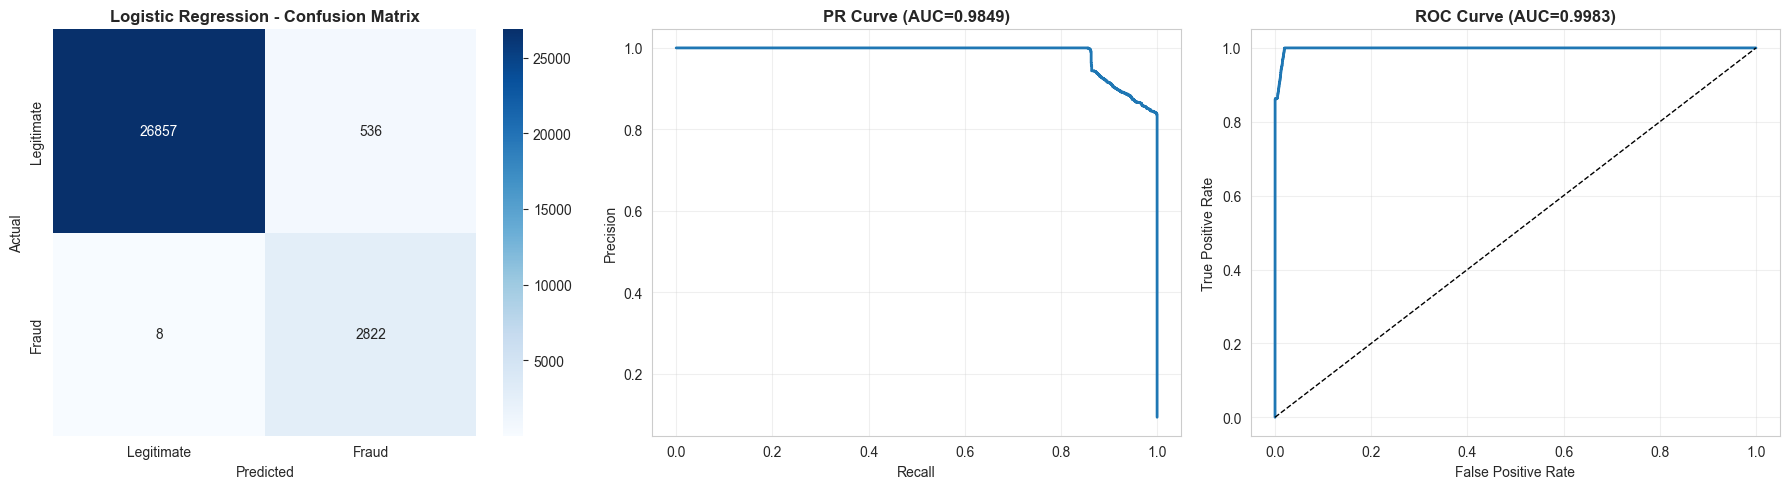


CROSS-VALIDATION: LOGISTIC REGRESSION (k=5)

📊 CROSS-VALIDATION RESULTS:
  PRECISION........... 0.8400 (±0.0079)
  RECALL.............. 0.9978 (±0.0010)
  F1.................. 0.9121 (±0.0047)
  ROC_AUC............. 0.9983 (±0.0001)
  PR_AUC.............. 0.9846 (±0.0011)


In [13]:
results = {}

# MODEL 1: Logistic Regression (Baseline)
print(f"\n{'#'*80}")
print("MODEL 1: LOGISTIC REGRESSION (BASELINE)")
print(f"{'#'*80}")

lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=Config.RANDOM_STATE,
    n_jobs=-1
)

lr_model.fit(X_train_scaled, y_train)
lr_metrics, lr_pred, lr_proba = evaluate_model(
    lr_model, X_test_scaled, y_test, 'Logistic Regression'
)
results['Logistic Regression'] = lr_metrics

# Cross-validation
lr_cv = cross_validate_model(lr_model, X_train_scaled, y_train, 
                              'Logistic Regression', cv=Config.CV_FOLDS)


################################################################################
MODEL 2: RANDOM FOREST
################################################################################

EVALUATING RANDOM FOREST

📊 METRICS:
  PRECISION........... 0.8370
  RECALL.............. 1.0000
  F1.................. 0.9113
  ROC_AUC............. 0.9988
  PR_AUC.............. 0.9885

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Legitimate       1.00      0.98      0.99     27393
       Fraud       0.84      1.00      0.91      2830

    accuracy                           0.98     30223
   macro avg       0.92      0.99      0.95     30223
weighted avg       0.98      0.98      0.98     30223

🎯 CONFUSION MATRIX:
  TN: 26,842  |  FP:    551
  FN:      0  |  TP:  2,830

💼 BUSINESS METRICS:
  Total Frauds: 2830
  Detected: 2830 (100.0%)
  Missed: 0 (0.0%)
  False Alarms: 551


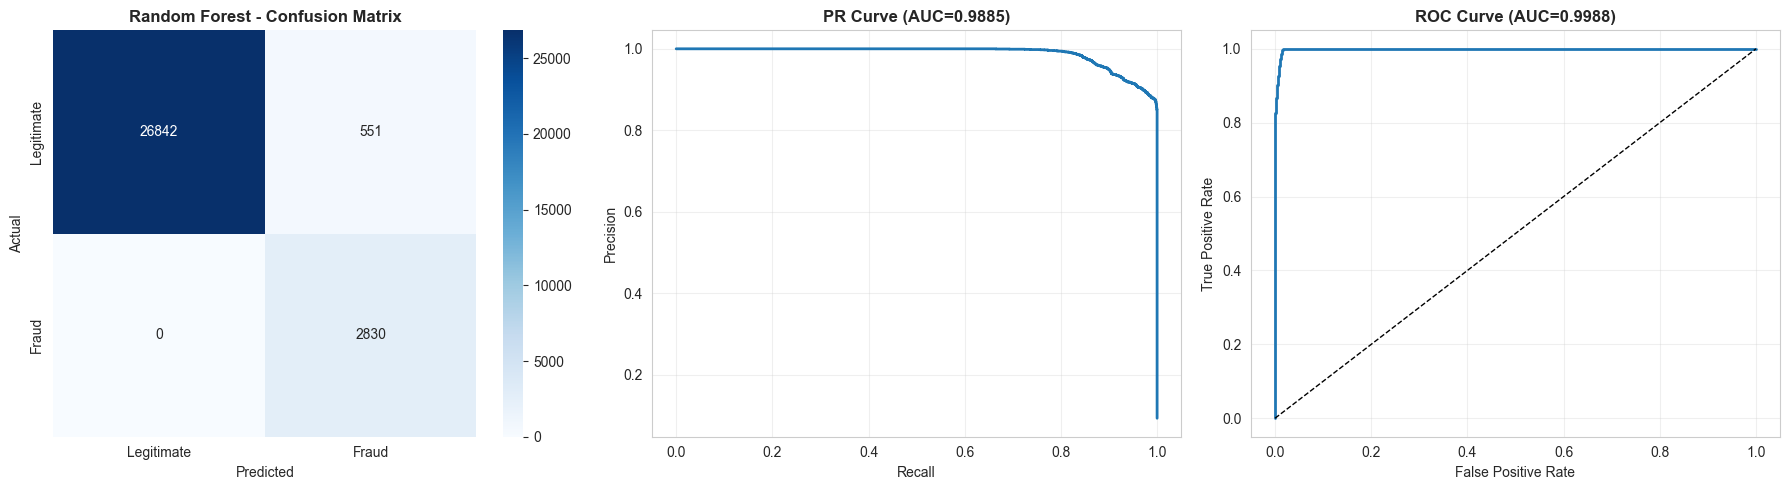


CROSS-VALIDATION: RANDOM FOREST (k=5)

📊 CROSS-VALIDATION RESULTS:
  PRECISION........... 0.8370 (±0.0077)
  RECALL.............. 0.9999 (±0.0002)
  F1.................. 0.9112 (±0.0045)
  ROC_AUC............. 0.9986 (±0.0002)
  PR_AUC.............. 0.9868 (±0.0016)


In [14]:
# MODEL 2: Random Forest
print(f"\n{'#'*80}")
print("MODEL 2: RANDOM FOREST")
print(f"{'#'*80}")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=Config.RANDOM_STATE,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
rf_metrics, rf_pred, rf_proba = evaluate_model(
    rf_model, X_test_scaled, y_test, 'Random Forest'
)
results['Random Forest'] = rf_metrics

# Cross-validation
rf_cv = cross_validate_model(rf_model, X_train_scaled, y_train,
                              'Random Forest', cv=Config.CV_FOLDS)


################################################################################
MODEL 3: XGBOOST
################################################################################

EVALUATING XGBOOST

📊 METRICS:
  PRECISION........... 0.8801
  RECALL.............. 0.9905
  F1.................. 0.9320
  ROC_AUC............. 0.9990
  PR_AUC.............. 0.9909

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Legitimate       1.00      0.99      0.99     27393
       Fraud       0.88      0.99      0.93      2830

    accuracy                           0.99     30223
   macro avg       0.94      0.99      0.96     30223
weighted avg       0.99      0.99      0.99     30223

🎯 CONFUSION MATRIX:
  TN: 27,011  |  FP:    382
  FN:     27  |  TP:  2,803

💼 BUSINESS METRICS:
  Total Frauds: 2830
  Detected: 2803 (99.0%)
  Missed: 27 (1.0%)
  False Alarms: 382


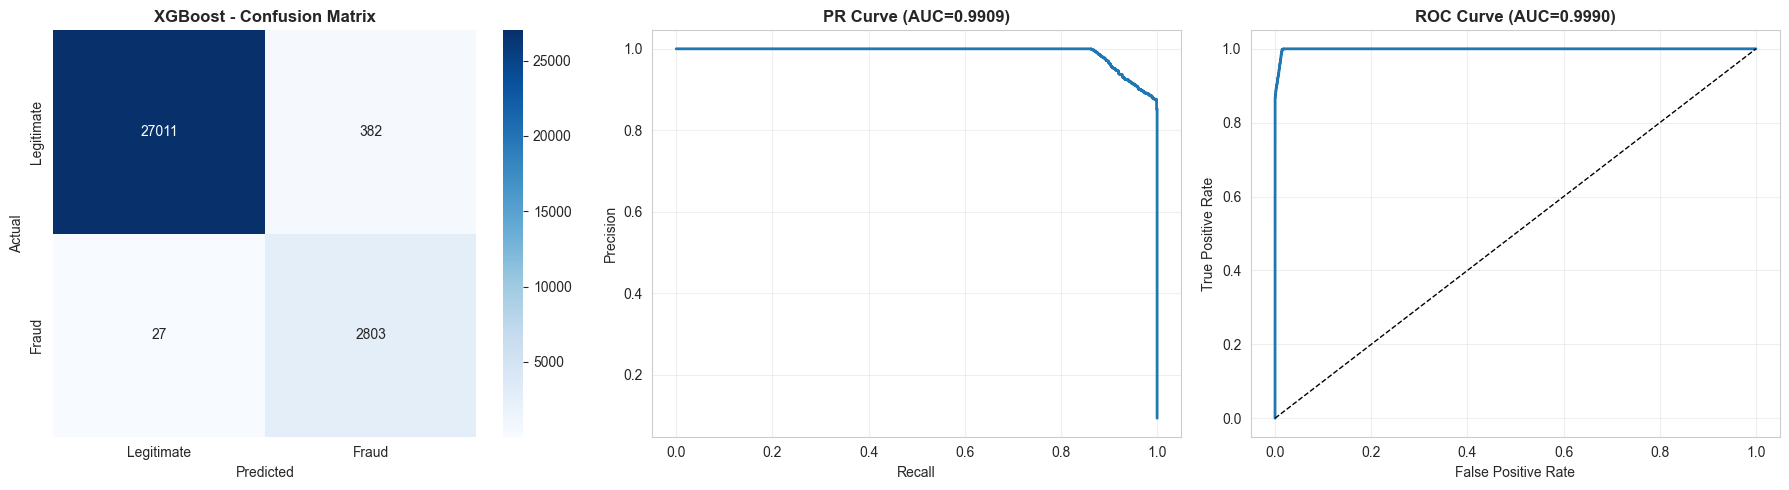


CROSS-VALIDATION: XGBOOST (k=5)

📊 CROSS-VALIDATION RESULTS:
  PRECISION........... 0.8840 (±0.0073)
  RECALL.............. 0.9892 (±0.0015)
  F1.................. 0.9336 (±0.0043)
  ROC_AUC............. 0.9990 (±0.0001)
  PR_AUC.............. 0.9909 (±0.0008)


In [15]:
# MODEL 3: XGBoost (if available)
if XGBOOST_AVAILABLE:
    print(f"\n{'#'*80}")
    print("MODEL 3: XGBOOST")
    print(f"{'#'*80}")
    
    # Calculate scale_pos_weight
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=Config.RANDOM_STATE,
        n_jobs=-1,
        eval_metric='aucpr'
    )
    
    xgb_model.fit(X_train_scaled, y_train)
    xgb_metrics, xgb_pred, xgb_proba = evaluate_model(
        xgb_model, X_test_scaled, y_test, 'XGBoost'
    )
    results['XGBoost'] = xgb_metrics
    
    # Cross-validation
    xgb_cv = cross_validate_model(xgb_model, X_train_scaled, y_train,
                                  'XGBoost', cv=Config.CV_FOLDS)


MODEL COMPARISON

                      precision  recall      f1  roc_auc  pr_auc
Logistic Regression     0.8404  0.9972  0.9121   0.9983  0.9849
Random Forest           0.8370  1.0000  0.9113   0.9988  0.9885
XGBoost                 0.8801  0.9905  0.9320   0.9990  0.9909


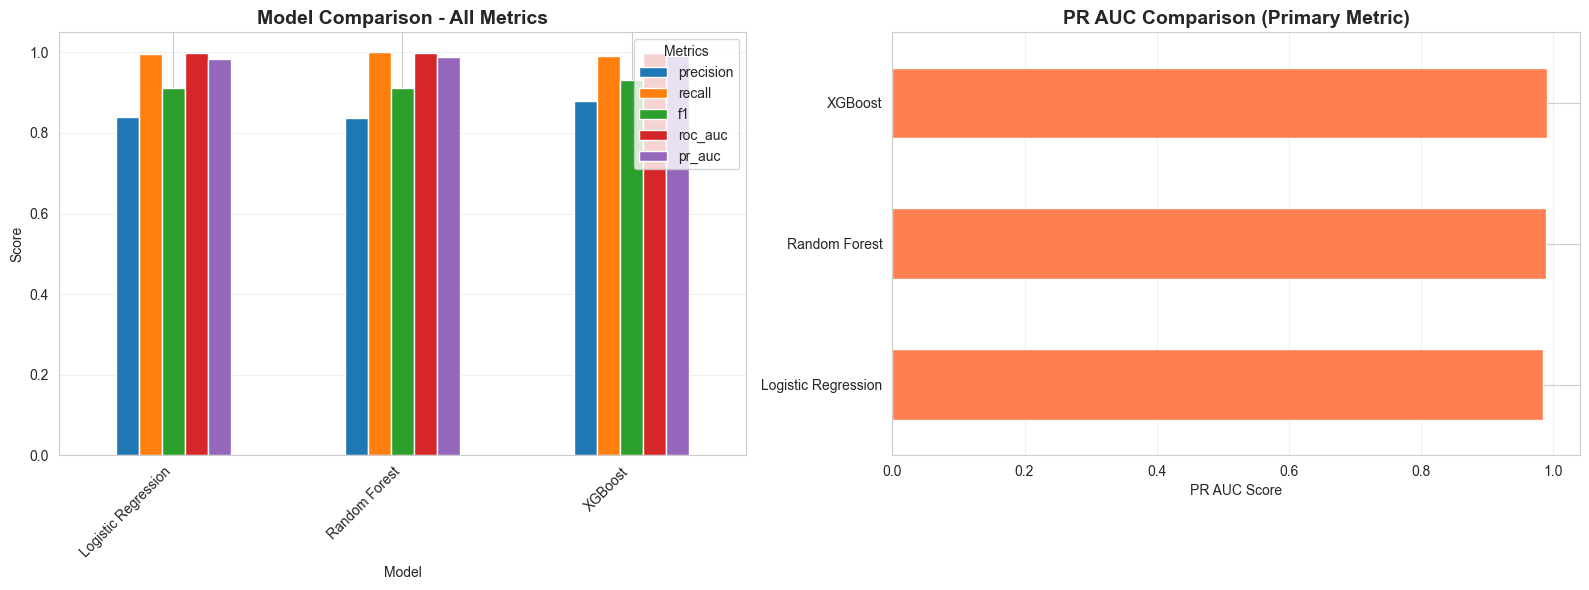


🏆 BEST MODEL: XGBoost
   PR AUC: 0.9909


In [16]:
# ==================== MODEL COMPARISON ====================
print(f"\n{'='*80}")
print("MODEL COMPARISON")
print(f"{'='*80}")

comparison_df = pd.DataFrame(results).T
print("\n", comparison_df.round(4))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
comparison_df.plot(kind='bar', ax=axes[0])
axes[0].set_title('Model Comparison - All Metrics', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].legend(title='Metrics')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# PR AUC comparison (most important for imbalanced data)
comparison_df['pr_auc'].plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('PR AUC Comparison (Primary Metric)', fontweight='bold', fontsize=14)
axes[1].set_xlabel('PR AUC Score')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(Config.PLOTS_DIR / 'fraud_model_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Select best model
best_model_name = comparison_df['pr_auc'].idxmax()
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   PR AUC: {comparison_df.loc[best_model_name, 'pr_auc']:.4f}")